# Summary
<br>
Code based on https://arxiv.org/abs/1902.09833 
<br> Simulating a two level system emmiting a photon into <u><b>mulitple</b></u> cavities using MPO's (opposed to qutip)
<br> Unsure how this is different form code 1

---

In [1]:
from einops import rearrange, reduce, repeat
import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint

In [2]:
t_final = 10

g = 1
rg = g**0.5

no_cav = 3
cav_dim = 2

# Finding $g_i(t)$'s

In [3]:
res = 500
c_time = np.linspace(0,t_final,res)
corel_c = qutip.destroy(2)
corel = qutip.correlation_2op_2t(qutip.qeye(2), qutip.fock(2,1), c_time, c_time, [rg*corel_c,], rg*corel_c.dag(), rg*corel_c)

#converting qutip format to t,t' format in paper
tdash_corel = np.zeros_like(corel)
for i in range(res):
    tdash_corel[i][i:] = corel[i][:(res-i)]
tdash_corel = tdash_corel + tdash_corel.T - (tdash_corel*np.eye(res))


n, func = np.linalg.eig(tdash_corel)
n = n/np.sum(n)                                     #renormalising for one photon
func_ = func/np.sqrt(c_time[1])                       #renormalising integration to one

v_funct = dict()
alpha_funct = dict()
g_funct = dict()
# format -> cav_no(i) influenced by cav_no(j)
# cav_no(i) if influenced by 0, means uninfluenced
#cavities are indexed 1 to no_cav

def da_vi_j(alpha, t ,i ,j ):
    da_vi_j = -(g_funct[j](t) * v_funct[i,j-1](t)) - (0.5*alpha*(g_funct[j](t))**2)
    return da_vi_j

def g_cnstr(v_list):
    return np.real(-v_list/(c_time[1]*np.cumsum(v_list**2))**0.5)

for i in range(1, no_cav+1):
    #cavity no is i 
    v_funct[i,0] = interp1d(c_time, np.real(func_[:,i-1]), kind='cubic', fill_value='extrapolate')

    for j in range(1,i):
        #cavity no i, influenced by cavity j
        # till j = i-1

        # generate alpha[i,j]
        alpha_list = odeint(da_vi_j,0,c_time,args=(i,j))[:,0]
        alpha_funct[i,j] = interp1d(c_time, alpha_list, kind='cubic',fill_value='extrapolate')

        #generate v[i,j]
        v_funct[i,j] = interp1d(c_time, (v_funct[i,j-1](c_time) + (g_funct[j](c_time) * alpha_funct[i,j](c_time))), kind='cubic',fill_value='extrapolate')

    # generate g[i]
    g_funct[i] = qutip.interpolate.Cubic_Spline(0, t_final, g_cnstr(v_funct[i,i-1](c_time)))


del (c_time, corel_c, corel, n, func, v_funct, alpha_funct )


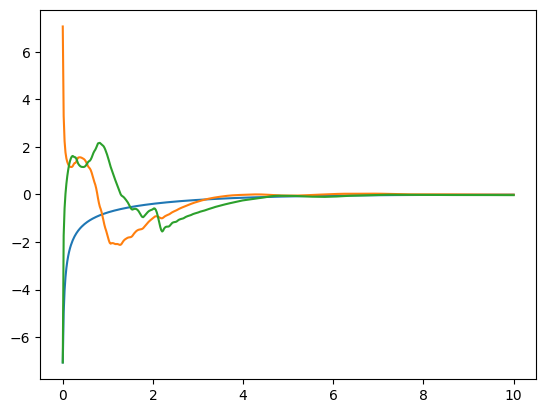

In [4]:
for i in range(1,1+no_cav):
    plt.plot(np.linspace(0,t_final,res), g_funct[i](np.linspace(0,t_final,res)))

# Initialising System

In [5]:
#atom_a 
c = qutip.destroy(2).full()

#atom_adag
cd = qutip.destroy(2).dag().full()

#cav_a 
a = qutip.destroy(cav_dim).full()

#cav_adag 
ad = qutip.destroy(cav_dim).dag().full()

In [6]:
mpo_list = list()

#adding atom
mpo_list.append(qutip.fock_dm(2,1).full()[np.newaxis,:,np.newaxis,:])

#adding cavities
for i in range(no_cav):
    mpo_list.append(qutip.fock_dm(cav_dim,0).full()[np.newaxis,:,np.newaxis,:])

# Functions

In [7]:
def svd_red(list_mpo):

    mpo_copy = list_mpo.copy()

    if mpo_copy[0].shape[0] > 1 :
        #print(mpo_copy[0].shape)
        mpo_copy[0] = np.sum(mpo_copy[0], axis=0)[np.newaxis, :, :, :]
    if mpo_copy[-1].shape[2] > 1 :
        #print(mpo_copy[-1].shape)
        mpo_copy[-1] = np.sum(mpo_copy[-1], axis=2)[ :, :, np.newaxis, :]

    reduced_list = [mpo_copy[0],]

    for i in range(no_cav):
        combine_mpo = rearrange( np.einsum( 'a b c d, c e f g-> a b e f d g' , reduced_list[i], mpo_copy[i+1]), 'a b e f d g -> (a b d) (e g f)')
        u, s, v = np.linalg.svd( combine_mpo , full_matrices=False)
        reduced_list[i] = rearrange( u, '(a b d) x -> a b x d', a=reduced_list[i].shape[0], b=reduced_list[i].shape[1], d=reduced_list[i].shape[3])
        reduced_list.append( rearrange(np.diag(s)@v, 'x (e g f) -> x e f g', e=mpo_copy[i+1].shape[1], g=mpo_copy[i+1].shape[3], f=mpo_copy[i+1].shape[2] ) )
    
    del(mpo_copy, combine_mpo, u, s, v)
    
    return reduced_list

In [8]:
def mpo_add(list1, list2):
    #assuming length of list1 and list 2 is the same
    sum_list = list()

    for i in range(len(list1)):
        #immutable axes are 1,3 of 0,1,2,3 
        s1 = list1[i].shape[1]
        s3 = list1[i].shape[3]
        '''
        if list1[i].shape[0] == 1 :
            sum_list.append(np.append( list1[i], list2[i], axis = 2 ))
        elif list1[i].shape[2] == 1 :
            sum_list.append(np.append( list1[i], list2[i], axis = 0 ))
        else: '''
        top = np.append( list1[i], np.zeros((list2[i].shape[0],s1,list1[i].shape[2],s3)), axis=0)
        bottom = np.append(np.zeros((list1[i].shape[0],s1,list2[i].shape[2],s3)),list2[i], axis =0)
        sum_list.append(np.append( top, bottom, axis=2 ))

    del( i, s1, s3, top, bottom)

    return svd_red(sum_list)


In [9]:
def mpo_mul(list1, list2):

    mul_list = list()

    for i in range(len(list1)):
        combine_term = np.einsum( 'a b c d, e d f g -> a e b c f g', list1[i], list2[i])
        combine_term = rearrange( combine_term, 'a e b c f g -> (a e) b (c f) g')
        mul_list.append(combine_term)

    del( combine_term)

    return svd_red(mul_list)

In [10]:
def mpo_trace(mpo_list):
    mpo_red = np.einsum('a b d b', mpo_list[0])
    for i in range(1,1+no_cav):
        combine_mpo =  np.einsum( 'a c, c e f e-> a f' , mpo_red, mpo_list[i])
        mpo_red = np.copy(combine_mpo)
    del(combine_mpo)
    return mpo_red[0,0]

def exp_val(mpo_list, cav_num = -1):
    if cav_num == -1 :
        return mpo_trace(mpo_list)
    else:
        n_op = ad@a
        if cav_num == 0:
            n_op = cd@c
        list_copy = mpo_list.copy()
        list_copy[cav_num] = np.einsum( 'x b, a b c d-> a x c d' , n_op, mpo_list[cav_num])
        return mpo_trace(list_copy) 


# Setting up Hamiltonian

In [11]:
pre_term = list([0,]*(no_cav+1))
post_term = list([0,]*(no_cav+1))
L_term = list([0,]*(no_cav+1))
Ld_term = list([0,]*(no_cav+1))

In [12]:
mpo_dim = 1 + no_cav + int((no_cav*0.5*(no_cav+1)))

In [13]:
for i in range(no_cav+1):
    #initialising mpo with appropriate size, all matrices at first
    if i == 0:
        pre_term[i] = np.array( list([ list([ np.zeros((2,2))])*mpo_dim ])*mpo_dim ) *0j
        post_term[i] = np.array( list([ list([ np.zeros((2,2))])*mpo_dim ])*mpo_dim ) *0j
        L_term[i] = np.array( list([ list([ np.zeros((2,2))])*(no_cav+1) ])*(no_cav+1) ) *0j
        Ld_term[i] = np.array( list([ list([ np.zeros((2,2))])*(no_cav+1) ])*(no_cav+1) ) *0j

        pre_term[i][0][0] = 0.5*g*cd@c
        post_term[i][0][0] = 0.5*g*cd@c
        L_term[i][0][0] = rg*c
        Ld_term[i][0][0] = rg*cd

        for j in range(1,1+no_cav):
            pre_term[i][j][j]  = rg*c
            post_term[i][j][j] = rg*cd
            L_term[i][j][j] = np.eye(2)
            Ld_term[i][j][j] = np.eye(2)

        for j in range(no_cav+1, mpo_dim):
            pre_term[i][j][j] = np.eye(2)
            post_term[i][j][j] = np.eye(2)
        
        pre_term[i] *= -1.0
        post_term[i] *= -1.0
        
    else:
        pre_term[i] = np.array( list([ list([ np.zeros((cav_dim,cav_dim))])*mpo_dim ])*mpo_dim ) *0j
        post_term[i] = np.array( list([ list([ np.zeros((cav_dim,cav_dim))])*mpo_dim ])*mpo_dim ) *0j
        L_term[i] = np.array( list([ list([ np.zeros((cav_dim,cav_dim))])*(no_cav+1) ])*(no_cav+1) ) *0j
        Ld_term[i] = np.array( list([ list([ np.zeros((cav_dim,cav_dim))])*(no_cav+1) ])*(no_cav+1) ) *0j

        pre_term[i][0][0] = np.eye(cav_dim)
        post_term[i][0][0] = np.eye(cav_dim)
        L_term[i][0][0] = np.eye(cav_dim)
        Ld_term[i][0][0] = np.eye(cav_dim)

        for j in range(1,1+no_cav):
            pre_term[i][j][j] = np.eye(cav_dim)
            post_term[i][j][j] = np.eye(cav_dim)
            L_term[i][j][j] = np.eye(cav_dim)
            Ld_term[i][j][j] = np.eye(cav_dim)
            if j==i :
                pre_term[i][j][j] = ad
                post_term[i][j][j] = a
                L_term[i][j][j] = a
                Ld_term[i][j][j] = ad
                
        index = 1 + no_cav
        
        for j in range(no_cav):
            for k in range(j+1):
                pre_term[i][index][index] = np.eye(cav_dim)
                post_term[i][index][index] = np.eye(cav_dim)
                if i == (j+1):
                    if j==k:
                        pre_term[i][index][index] = 0.5*ad@a
                        post_term[i][index][index] = 0.5*ad@a
                    else:
                        pre_term[i][index][index] = ad
                        post_term[i][index][index] = a
                else:
                    if i==k+1:
                        pre_term[i][index][index] = a
                        post_term[i][index][index] = ad
                index += 1
    
    pre_term[i] = rearrange(pre_term[i], 'a b c d-> a c b d')
    post_term[i] = rearrange(post_term[i], 'a b c d-> a c b d')
    L_term[i] = rearrange(L_term[i], 'a b c d-> a c b d')
    Ld_term[i] = rearrange(Ld_term[i], 'a b c d-> a c b d')


In [14]:
#to add time updating Mpo 

def time_update(time_):

    for i in range(1,no_cav+1):
        #initialising mpo with appropriate size, all matrices at first
        for j in range(1,1+no_cav):
            if j==i :
                pre_term[i][j,:,j,:] = g_funct[i](time_) * ad
                post_term[i][j,:,j,:] = g_funct[i](time_) * a
                L_term[i][j,:,j,:] = g_funct[i](time_) * a
                Ld_term[i][j,:,j,:] = g_funct[i](time_) * ad          
        index = 1 + no_cav
        for j in range(no_cav):
            for k in range(j+1):
                if i == (j+1):
                    if j==k:
                        pre_term[i][index,:,index,:] = 0.5 * np.square(g_funct[i](time_)) * ad@a
                        post_term[i][index,:,index,:] = 0.5 * np.square(g_funct[i](time_)) * ad@a
                    else:
                        pre_term[i][index,:,index,:] = g_funct[i](time_) * ad
                        post_term[i][index,:,index,:] = g_funct[i](time_) * a
                else:
                    if i==k+1:
                        pre_term[i][index,:,index,:] = g_funct[i](time_) * a
                        post_term[i][index,:,index,:] = g_funct[i](time_) * ad
                index += 1
    

# Time Evolution

In [15]:
time_series = np.linspace(0,t_final,50)
dt = time_series[1]

#mpo at ith time step
mpo_i = mpo_list.copy()

exp_values_list = list()
for i in range(1+no_cav):
    exp_values_list.append(list([exp_val(mpo_i,i)]))
exp_values_list.append(list([exp_val(mpo_i)]))

for time_ in time_series[1:]:

    time_update(time_)
    
    term_1 = mpo_mul(pre_term,mpo_i)
    term_2 = mpo_mul(mpo_i, post_term)
    term_3 = mpo_mul(mpo_mul(L_term, mpo_i), Ld_term)

    d_rho = mpo_add(mpo_add(term_1, term_2), term_3)
    d_rho[0] *= dt

    mpo_i = mpo_add(mpo_i, d_rho)
    trace_ = exp_val(mpo_i)
    mpo_i[0] /= trace_

    for i in range(1+no_cav):
        exp_values_list[i].append(exp_val(mpo_i,i))
    exp_values_list[-1].append(exp_val(mpo_i, -1))


/Users/ygup3491/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


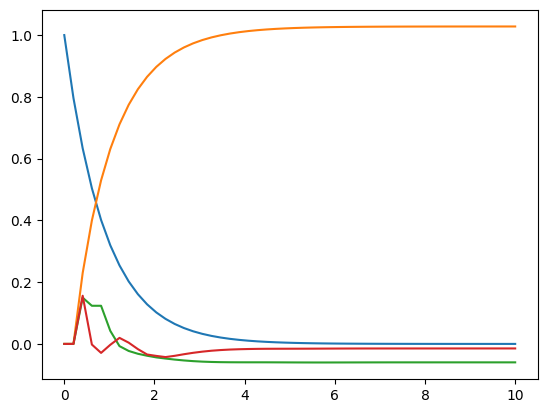

In [16]:

for i in range(1+no_cav):
    plt.plot(time_series, exp_values_list[i])
#plt.plot(time_evol, cav_2)

In [4]:
np.exp(1j*np.pi*np.eye(3))

array([[-1.+1.2246468e-16j,  1.+0.0000000e+00j,  1.+0.0000000e+00j],
       [ 1.+0.0000000e+00j, -1.+1.2246468e-16j,  1.+0.0000000e+00j],
       [ 1.+0.0000000e+00j,  1.+0.0000000e+00j, -1.+1.2246468e-16j]])

In [6]:
np.eye(2)*2 @ np.log(np.eye(2)*2)

/var/folders/s9/whvhj6gs5cx001kw71n2wfqr0000gq/T/ipykernel_82924/1906294815.py:1: RuntimeWarning: divide by zero encountered in log
  np.eye(2)*2 @ np.log(np.eye(2)*2)
/var/folders/s9/whvhj6gs5cx001kw71n2wfqr0000gq/T/ipykernel_82924/1906294815.py:1: RuntimeWarning: invalid value encountered in matmul
  np.eye(2)*2 @ np.log(np.eye(2)*2)


array([[ nan, -inf],
       [-inf,  nan]])